# Table of Contents

1. [Importing Libraries](#importing-libraries)
2. [Reading Data](#reading-data)
3. [Exploratory Data Analysis](#eda)
    - 3.1 [Data Cleaning](#data-cleaning)
    - 3.2 [Preprocessing](#preprocess)
        - 3.2.1 [Outlier Removal](#outlier-removal)
        - 3.2.2 [Feature Engineering](#fe)
    - 3.3 [Data Visualization](#data-visualization)
    - 3.4 [Train Test Split](#tts)

4. [Model Building](#mb)
    - 4.1 [Linear Regression](#lr)
    - 4.2 [Decision Tree Regression](#dtr)
    - 4.3 [Random Forest Regression](#rfr)
    - 4.4 [KNearest Neighbor Regression](#knnr)
    - 4.5 [Gradient Boosting Regression](#gbr)
    - 4.6 [Bayesian Ridge Regression](#brr)

5. [Model Evaluation and Selection](#mes)
    - [Hyperparameter Tuning](#hpt)
    - [Final Model](#final-model)
    - [Saving Model](#sm)
6. [Sample Predictions](#sp)

<a id='importing-libraries'></a>
# 1. Importing Libraries

In [3]:
#data management
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import loguniform

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

#preprocessing
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, KFold

#parameter tuning
from sklearn.model_selection import RandomizedSearchCV as RSCV

#models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge

#metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score

#saving model
import pickle

%matplotlib inline

<a id='reading-data'></a>
# 2. Reading Data

In [4]:
data = pd.read_csv('/kaggle/input/indian-movie-data-questt/movie-data.csv', encoding='latin-1')
data

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
...,...,...,...,...,...,...,...,...,...,...
15504,Zulm Ko Jala Doonga,(1988),NaN,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15506,Zulmi Raj,(2005),NaN,Action,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN
15507,Zulmi Shikari,(1988),NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#renaming and rearranging columns
data.columns = [
    'movie', 'year', 'duration', 'genre', 'rating', 'votes', 'director',
    'actor1', 'actor2', 'actor3'
]
data = data[[
    'movie', 'year', 'genre', 'duration', 
    'director', 'actor1', 'actor2', 'actor3', 
    'votes', 'rating'
]]

<a id='eda'></a>
# 3. Exploratory Data Analysis

In [6]:
data.sample(5)

,movie,year,genre,duration,director,actor1,actor2,actor3,votes,rating
10433,Padmashree Laloo Prasad Yadav,(2005),Comedy,162 min,Mahesh Manjrekar,Sunil Shetty,Masumeh Makhija,Mahesh Manjrekar,185,2.4
6872,Jungle Ki Duniya,(1959),Action,NaN,Indira,Kailash Kumar,NaN,NaN,NaN,NaN
14528,Tumhare Liye,(1978),"Drama, Family",NaN,Basu Chatterjee,Sanjeev Kumar,Vidya Sinha,Ashok Kumar,36,6.0
8216,Life Mein Time Nahi Hai Kisi Ko,(2019),"Comedy, Drama",119 min,Manoj Sharma,Rajniesh Duggall,Krishna Abhishek,Yuvika Chaudhary,23,7.1
5993,I Love You Teacher,(1989),Thriller,123 min,Bhanupriya,Krishna Ghattamaneni,Charan Raj,NaN,NaN,NaN


In [7]:
data.shape

(15509, 10)

**Percentage of nan Values based on Columns**

In [8]:
(data.isnull().sum()/len(data))*100

movie        0.000000
year         3.404475
genre       12.102650
duration    53.317429
director     3.385131
actor1      10.426204
actor2      15.371720
actor3      20.272100
votes       48.932878
rating      48.939326
dtype: float64

Data contains quite a lot of null values

<a id='data-cleaning'></a>
## 3.1 Data Cleaning

In [9]:
#creating a deep copy of original data
df = data.copy(True)

Removing rows where `df['actor1'].isnull() == True`

In [10]:
df = df[~(df['actor1'].isnull())]

In [11]:
df.isnull().sum()

movie          0
year         399
genre       1485
duration    6916
director       0
actor1         0
actor2       767
actor3      1527
votes       6097
rating      6098
dtype: int64

In [12]:
data.shape, df.shape

((15509, 10), (13892, 10))

Combining Lead Actors into single column in list format

In [13]:
#convert actor1-3 into single column containing
#selecting only non-NAN values
#remove cols = [actor1, actor2, actor3]
def combine_actors(df):
    print('Updating Actors...')
    cols = ['actor1', 'actor2', 'actor3']
    df['actors'] = [[x for x in row if x==x] for row in df[cols].values.tolist()]
    df.drop(['actor1', 'actor2', 'actor3'], axis = 1, inplace=True) #drop individual actor columns
    return df

In [14]:
df = combine_actors(df)
df.sample(5)

Updating Actors...


,movie,year,genre,duration,director,votes,rating,actors
668,Africa,(1954),Action,NaN,K. Kant,NaN,NaN,"[Habib, Krishna Kumari, Baburao Pahelwan]"
885,Aman,(1967),"Adventure, Drama, Romance",152 min,Mohan Kumar,41,6.5,"[Rajendra Kumar, Saira Banu, Balraj Sahni]"
8668,Main Hoon Jadugar,(1965),NaN,NaN,Jugal Kishore,NaN,NaN,"[Chitra, Paidi Jairaj, Ravikant]"
8142,Lamhaa: The Untold Story of Kashmir,(2010),"Action, Drama, Thriller",152 min,Rahul Dholakia,626,5.0,"[Sanjay Dutt, Bipasha Basu, Kunal Kapoor]"
179,Aa Gale Lag Jaa,(1973),"Action, Drama, Romance",148 min,Manmohan Desai,348,7.2,"[Shashi Kapoor, Sharmila Tagore, Shatrughan Si..."


### Removing all rows containing any nan

In [15]:
#dropping rows with any nan value
df.dropna(inplace=True)
df.shape

(5746, 8)

In [16]:
print(f'Percentage Reduction in Dataset Size after Cleaning: {round(100*(1 - df.shape[0]/data.shape[0]), 3)}%')

Percentage Reduction in Dataset Size after Cleaning: 62.951%


In [17]:
#rearranging columns
df = df[[
    'movie', 'year', 'genre', 'duration', 
    'director', 'actors', 'votes', 'rating'
]]
df.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
14856,Viduthalai,(1986),Action,148 min,K. Vijayan,"[Shivaji Ganesan, Rajinikanth, Vishnuvardhan]",57,6.5
13799,Tarang,(1984),Drama,171 min,Kumar Shahani,"[Amol Palekar, Smita Patil, Shreeram Lagoo]",47,6.9
3561,Deewana Main Deewana,(2013),"Comedy, Drama, Romance",130 min,K.C. Bokadia,"[Govinda, Priyanka Chopra Jonas, Nasir Khan]",339,2.4
7363,Kasaai,(2019),Drama,96 min,Gajendra Shanker Shrotriya,"[Raman Atre, Ashok Banthia, Amit Bimrot]",29,6.6
14085,The Great Gambler,(1979),"Action, Crime, Romance",105 min,Shakti Samanta,"[Amitabh Bachchan, Zeenat Aman, Neetu Singh]",619,6.5


<a id='preprocess'></a>
## 3.2 Preprocessing

**Preprocessing Steps**

1. year: remove brackets, convert object into int
2. genre: convert comma separated into list
3. duration: remove 'mins' and convert object into int
4. director: convert into list
5. votes: remove ',' and convert object into int
6. update index


In [18]:
class Preprocessor:
    #remove brackets, convert object into int
    def update_year(self, years):
        print('Processing years...')
        return [int(y[1:5]) for y in years]

    #convert into list
    def update_genre(self, genres):
        print('Processing genres...')
        return [g.split(',') for g in genres]
    
    #remove 'mins', convert into int
    def update_duration(self, durations):
        print('Processing duration...')
        return [int(d.split()[0]) for d in durations]
    
    #converting into list
    def update_director(self, directors):
        print('Processing director...')
        return [[d] for d in directors]
    
    #remove "," and  convert object into int
    def update_votes(self, votes):
        print('Processing votes...')
        return [int(''.join(v.split(','))) for v in votes]
    
    #remove and update index
    def update_index(self, df):
        print('Updating Index...')
        df.reset_index(inplace=True)
        df.drop(['index'], axis = 1, inplace=True)
        return df
    
    def transform(self, df):
        df = df.copy()
        
        print('\n||| Preprocessing... |||\n')
        
        df['year'] = self.update_year(df['year'])
        df['genre'] = self.update_genre(df['genre'])
        df['duration'] = self.update_duration(df['duration'])
        df['director'] = self.update_director(df['director'])
        df['votes'] = self.update_votes(df['votes'])
        df = self.update_index(df)
        
        print('\n||| Preprocessing Complete. |||\n')
        print(f'Dataset Shape: {df.shape}')
        
        return df

In [19]:
#class object to aid with preprocessing
pr = Preprocessor()

In [20]:
df_pr = pr.transform(df)


||| Preprocessing... |||

Processing years...
Processing genres...
Processing duration...
Processing director...
Processing votes...
Updating Index...

||| Preprocessing Complete. |||

Dataset Shape: (5746, 8)


In [21]:
df_pr.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
4759,Shaukeen,1982,[Comedy],127,[Basu Chatterjee],"[Ashok Kumar, A.K. Hangal, Utpal Dutt]",446,7.2
4220,Queens! Destiny of Dance,2011,"[Drama, Musical]",112,[David Atkins],"[Seema Biswas, Vineeth]",10,5.4
2491,Janta Hawaldar,1979,"[Comedy, Crime, Drama]",126,[Mehmood],"[Rajesh Khanna, Ashok Kumar, Yogeeta Bali]",44,6.5
5534,Wake Up Sid,2009,"[Comedy, Drama, Romance]",138,[Ayan Mukherjee],"[Ranbir Kapoor, Konkona Sen Sharma, Supriya Pa...",29167,7.6
265,Acid Factory,2009,"[Action, Crime, Mystery]",108,[Suparn Varma],"[Fardeen Khan, Dia Mirza, Manoj Bajpayee]",677,5.0


**Pandas Automated Profiling Report**

In [22]:
profile_pr = ProfileReport(df_pr, title="Pandas Profiling Report", explorative=True)
profile_pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Observations based on Pandas Report**
1. movie: contains some duplicate values, but has different features hence no need to remove
2. votes: is highly skewed! Contains very high values (Min: 5, Max: 591417)
    - outlier removal required
3. year: ranges between 1931 to 2021, skewed towards higher end
4. duration: ranges between 21 to 321, nearly normal distribution
5. rating: normal distribution

* Top 5 Genres
    - drama -> 31.4%
    - action -> 15.4%
    - romance -> 10.6%
    - comedy -> 8.8%
    - thriller -> 7.4%

In [23]:
df_pr.describe()

,year,duration,votes,rating
count,5746.000000,5746.000000,5746.000000,5746.000000
mean,1996.466934,132.796554,2658.097633,5.911591
std,19.706613,25.896470,13551.521795,1.385306
min,1931.000000,21.000000,5.000000,1.100000
25%,1983.000000,118.000000,30.000000,5.000000
50%,2002.000000,135.000000,126.000000,6.100000
75%,2013.000000,150.000000,886.250000,6.900000
max,2021.000000,321.000000,591417.000000,10.000000


<a id='outlier-removal'></a>
### 3.2.1 Outlier Removal

Votes contains highly skewed values which will affect the model

Text(0.5, 1.0, 'Votes Histogram without NANs')

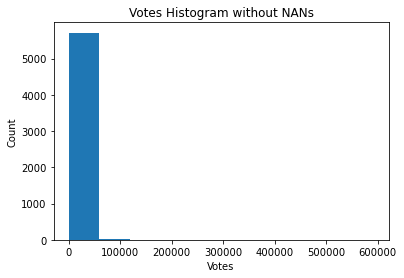

In [24]:
#histogram for all votes
plt.hist(df_pr.votes)

plt.xlabel('Votes')
plt.ylabel('Count')
plt.title('Votes Histogram without NANs')

Text(0.5, 1.0, 'Votes Histogram without NANs')

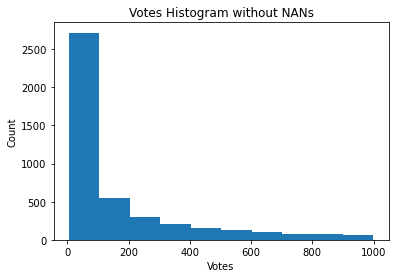

In [25]:
#histogram for votes < 1000
plt.hist(df_pr.loc[df_pr['votes'] < 1000].votes)

plt.xlabel('Votes')
plt.ylabel('Count')
plt.title('Votes Histogram without NANs')

Box Plot using seaborn for votes

<AxesSubplot:xlabel='votes'>

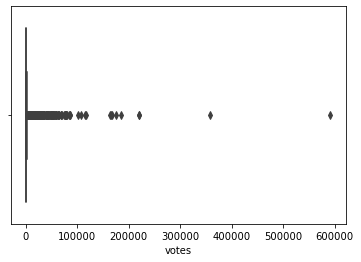

In [26]:
sns.boxplot(x=df_pr['votes'])

Scatter Plot using pyplot

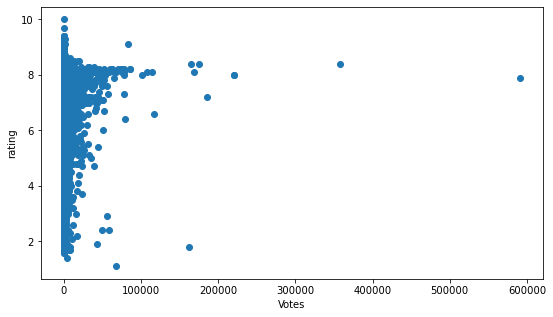

In [27]:
# Scatter plot for votes vs rating
fig, ax = plt.subplots(figsize = (9,5))

ax.scatter(df_pr['votes'], df_pr['rating'])
ax.set_xlabel('Votes') # x-axis label
ax.set_ylabel('rating') # y-axis label
plt.show()

Based on the box plot and scatter plot we can see that there are several outliers beyond 87000

**Removing outliers using Inter Quartile Range**

In [28]:
Q1 = np.percentile(df_pr['votes'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df_pr['votes'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Shape Before: ", df_pr.shape)
 
#Upper bound
upper = np.where(df_pr['votes'] >= (Q3+1.5*IQR))
#Lower bound
lower = np.where(df_pr['votes'] <= (Q1-1.5*IQR))
 
#Removing the Outliers beyond upper and lower bound
df_pr = df_pr.drop(upper[0])
df_pr = df_pr.drop(lower[0])
 
print("Shape After: ", df_pr.shape)

Shape Before:  (5746, 8)
Shape After:  (4803, 8)


<AxesSubplot:xlabel='votes'>

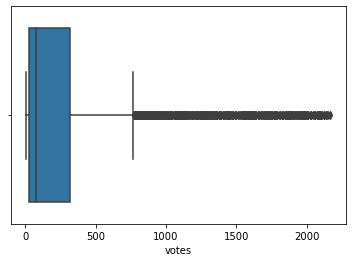

In [29]:
#box plot for votes after outlier removal
sns.boxplot(x=df_pr['votes'])

Nearly 950 outliers were removed

<a id='fe'></a>
### 3.2.2 Feature Engineering

Converting Categorical Values (Genres, Director, Actors) into Unique Numerical Values

**Steps** for Genres, Director, Actors:

1. Identyfing Unique sub-features per Feature
2. Creating a Binary Representation for Each Feature
3. Find Concentration points and a Decimal Value to Represent Concentration Points
4. Normalize Features

**Step 1: Identifying unique sub-features per feature**

In [30]:
df_pr = pr.update_index(df_pr)

Updating Index...


In [31]:
df_pr.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
2983,Mohre,1987,"[Drama, Mystery]",104,[Raghuvir Kul],"[Nana Patekar, Madhuri Dixit, Sadashiv Amrapur...",75,5.3
191,Aashmani Jawaharat,2014,[Drama],132,[Sriparna Dey],"[Anamitra Roy, Anamitra Roy, Yovik]",10,6.1
3057,Muqabla,1993,"[Action, Crime, Drama]",162,[Rama Rao Tatineni],"[Govinda, Karisma Kapoor, Farha Naaz]",171,4.2
4164,Super Model,2013,"[Drama, Mystery, Romance]",83,[Navin Batra],"[Ashmit Patel, Veena Malik, Sana Oberoi]",180,1.9
1970,International Crook,1974,"[Action, Crime]",138,[Pachhi],"[Dharmendra, Saira Banu, Feroz Khan]",62,6.5


In [32]:
#strip white spaces, remove duplicates
def clean_list(l):
    l = [x.strip() for x in l]
    clean = [i for j, i in enumerate(l) if i not in l[:j]] 
    return clean

#for genre, actors, director
def generate_list(df, feature_name): #create a list of all unique feature values
    #Step 1: track ratings associated with each feature in a dictionary
    feature_dict = {}
    for index, row in df.iterrows():
        feat = row[feature_name]
        #for subfeatures in a feature
        for sub_feat in feat:
            if sub_feat not in feature_dict:
                feature_dict[sub_feat] = (df['rating'][index], 1)
            else:
                feature_dict[sub_feat] = (feature_dict[sub_feat][0] + (df['rating'][index]), feature_dict[sub_feat][1] + 1)

    #Step 2: calculate average ratings for each feature
    for key in feature_dict:
        feature_dict[key] = feature_dict[key][0]/feature_dict[key][1] #average of all ratings
       
    #Step 3: create and sort list of tuples (dictionary value, key)
    lst = list()
    for name in feature_dict:
        lst.append((feature_dict[name],name))
    lst = sorted(lst)
    
    #Step 4: create a list of only feature names, from lowest rating to highest rating
    feature_list = list()
    ratings_list = list()
    for element in lst:
        feature_list.append(element[1].strip())
        ratings_list.append(element[0])
    
    #variance of ratings for determining importance of the information
    var = round(np.var(ratings_list), 3)
    
    #visualize, then return list
    fig, ax = plt.subplots(figsize=(6,5))
    
    if feature_name != 'genre':
        n = 50 #sample at intervals of n
    else: #genre contains few unique types
        n = 1

    X = [] #sample for associated movie rating
    Y = [] #sample for feature names
    for i in range(0, len(feature_list) - 1, n):
        X.append(ratings_list[i])
        Y.append(feature_list[i])
    
    feature_list = clean_list(feature_list)
    
    y_pos = np.arange(len(Y))
    ax.barh(y_pos, X, align='center')
    ax.invert_yaxis()  #labels read top-to-bottom
    ax.set_xlabel('ratings')
    ax.set_ylabel(feature_name + ' sample list index')
    ax.set_title(feature_name + ' to associated movie(s) performance (' + str(int(len(feature_list)/n)) + ' samples), variance: ' + str(var))
    
    plt.show()
    
    return feature_list

**Creating List for each feature**

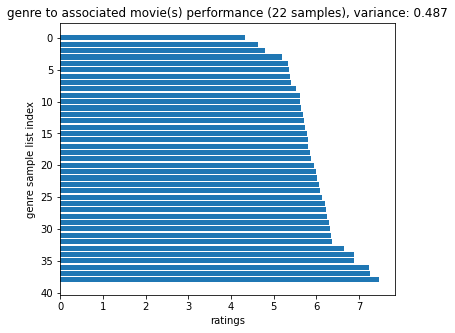

Unique Genres: 22


In [33]:
genre_list = generate_list(df_pr, 'genre')
print(f'Unique Genres: {len(genre_list)}')

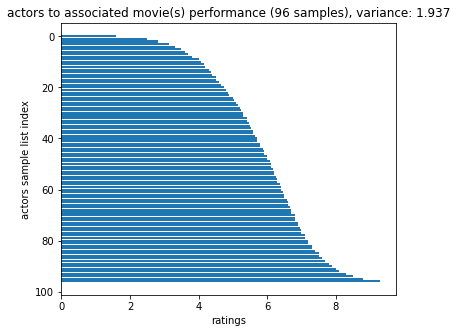

Unique Actors: 4819


In [34]:
actors_list = generate_list(df_pr, 'actors')
print(f'Unique Actors: {len(actors_list)}')

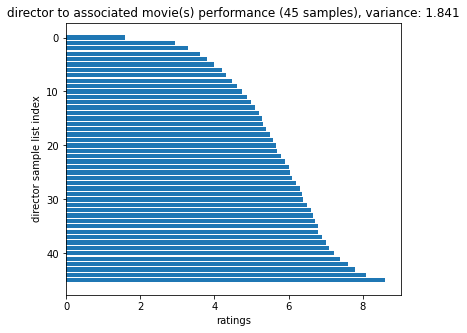

Unique Directors: 2287


In [35]:
director_list = generate_list(df_pr, 'director')
print(f'Unique Directors: {len(director_list)}')

**Analysis**

<table>
    <tr>
        <th>Feature</th>
        <th>Variance</th>
    </tr>
    <tr>
        <td>Genre</td>
        <td>0.48</td>
    </tr>
    <tr>
        <td>Actors</td>
        <td>1.93</td>
    </tr>
    <tr>
        <td>Director</td>
        <td>1.84</td>
    </tr>
</table>


Based on above variances, it can be concluded that genres will not be useful for predicting a movie's rating since it has a very low variance.

However, the Actors and Director have high variances, hence they will be useful

Genres wont be included in the features model1

In [36]:
df_pr.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
4549,Vaibhav Sethia: Don't,2018,[Comedy],61,[Manu Prakash Singh],[Vaibhav Sethia],187,6.9
1862,Hulla,2008,"[Comedy, Drama]",107,[Jaideep Varma],"[Sushant Singh, Kartika Rane, Rajat Kapoor]",234,6.4
1336,Double Cross: Ek Dhoka,2005,[Comedy],104,[Vicky Tejwani],"[Ayesha Jhulka, Negar Khan, Sahil Khan]",44,4.2
3176,Neel Kamal,1947,"[Drama, Musical, Romance]",116,[Kidar Nath Sharma],"[Begum Para, Raj Kapoor, Madhubala]",75,7.7
3727,Rowdy Inspector,1992,"[Action, Drama]",143,[Gopal B.],"[Nandamuri Balakrishna, Annapoorna, Brahmanandam]",115,6.0


**Step 2: Create binary representation for each feature**

Using the lists created, creating binary arrays that indicate presence of feature_name in movie

(each array represents a feature associated with movies with lowest average ratings to highest average ratings)

In [37]:
def calculate_bin_array(curr, all_features):
    bin_list = []
    for element in all_features:
        if element in curr: #1 if present
            bin_list.append(1)
        else: #0 if absent
            bin_list.append(0)
    return bin_list

In [38]:
#repeating for director, actors and genre
fts, ftslist = ['director', 'actors', 'genre'], [director_list, actors_list, genre_list]
for i in range(3):
    df_pr[fts[i]] = df_pr[fts[i]].apply(lambda x: calculate_bin_array(x, ftslist[i]))

In [39]:
df_pr.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
545,Baat Ek Raat Ki,1962,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",145,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,6.8
3658,Raton Ki Rani (The Night Queen),2004,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,3.5
3840,Sangeet,1992,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",150,5.6
3717,Roohi,1981,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,2.6
2772,Main Tere Pyaar Mein Pagal,1999,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",146,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,4.7


**Visualize Distribution of 1's in Number Line Form**

In [40]:
def plot_bin(row):
    director_bin = row[4] #read director name
    director_index = []
    for i in range(len(director_bin)): # create arrays of indices where bin number is one
        if director_bin[i] == 1:
            director_index.append(i)
    
    actors_bin = row[5] #read actor names
    actors_index = []
    for i in range(len(actors_bin)): # create arrays of indices where bin number is one
        if actors_bin[i] == 1:
            actors_index.append(i)
            
    genre_bin = row[2] #read genre
    genre_index = []
    for i in range(len(genre_bin)): # create arrays of indices where bin number is one
        if genre_bin[i] == 1:
            genre_index.append(i)
    
    font = {
        'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 10,
    }
    
    fig, ax = plt.subplots(3, 1, figsize=(10,1))
    plt.subplots_adjust(hspace = 5)
    
    ax[0].scatter(director_index, np.zeros_like(director_index), vmin=-2)
    ax[0].set_title('Director', loc = 'left', fontdict=font)
    ax[0].set_xlim(0,len(director_bin))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    
    ax[1].scatter(actors_index, np.zeros_like(actors_index), vmin=-2)
    ax[1].set_title('Actors', loc = 'left', fontdict=font)
    ax[1].set_xlim(0, len(actors_bin))
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    
    ax[2].scatter(genre_index, np.zeros_like(genre_index), vmin=-2)
    ax[2].set_title('Genres', loc = 'left', fontdict=font)
    ax[2].set_xlim(0, len(genre_bin))
    ax[2].set_yticks([])
    ax[2].set_xticks([])

In [41]:
df_sample = df_pr.sample(20)

the blue markings represent a 1 indicating presence of a specific element

Movie: Hum Sab Chor Hain
Rating: 3.5



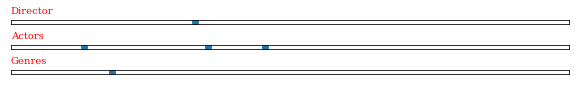

In [42]:
i = 7 #vary this
print('Movie: ' + str(df_sample.iloc[i][0]) + '\nRating: ' + str(df_sample.iloc[i][-1]) + '\n')
plot_bin(df_sample.iloc[i])

**Step 3: Find concentration points in each array**

Find areas where numbers are grouped together, and identify points resembling center of binary distribution

In [43]:
def split_arr(arr, n_splits): 
    # looping till length l 
    for i in range(0, len(arr), n_splits):  
        yield arr[i:i + n_splits] 

def find_conc(arr, n): # n is the number of concentration points to find
    #seperate array into batches
    batches = list(split_arr(arr, int(len(arr)/n)))
    conc = []
    for i in range(len(batches)):
        point = 0
        num_ones = 0
        for j in range(len(batches[i])):
            if batches[i][j] == 1:
                point += j + (i * int(len(arr)/n)) # adding correction for batches
                num_ones += 1
        if num_ones > 0:
            point = point/num_ones
            conc.append((round(point, 2),num_ones))
    return conc

def to_conc(df, feature_names):
    for feature_name in feature_names:
        n = 100 if feature_name!='genre' else 1
        print('feature: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: find_conc(x, n))
    return df

In [44]:
# repeating for director, actors, genre
df_pr = to_conc(df_pr, ['director', 'actors', 'genre'])

feature:  director
feature:  actors
feature:  genre


In [45]:
df_pr.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
345,Amber,1952,"[(4.0, 1)]",141,"[(1859.0, 1)]","[(3325.0, 1), (3871.0, 1), (4181.0, 1)]",65,6.9
2256,Kahaani Gudiya Ki...: True Story of a Woman,2008,"[(18.0, 1)]",112,"[(1100.0, 1)]","[(1583.0, 1), (1808.0, 1), (3058.0, 1)]",32,5.8
1647,Godam,1983,"[(8.0, 1)]",140,"[(1923.0, 1)]","[(3893.0, 1), (3955.0, 1), (4308.0, 1)]",37,7.1
2406,Khazanchi,1941,"[(10.0, 1)]",171,"[(932.0, 1)]","[(1349.0, 1), (3819.0, 1), (3842.0, 1)]",26,7.0
2326,Karle Pyaar Karle,2014,"[(4.0, 1)]",110,"[(30.0, 1)]","[(68.5, 2), (873.0, 1)]",128,2.7


**Step 3.1: Find a decimal value that represents the concentration points**

- point represents weighted average of all points of concentration 
- weight is number of ones for each concentration point

In [46]:
def w_avg(arr):
    weight = 0 #weight
    s = 0 # position*weight
    for element in arr:
        s += (element[0] * element[1])
        weight += element[1]
    return round(s/weight, 4) #weighted average

def to_weighted_avg(df, feature_names):
    for feature_name in feature_names:
        print('Current: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: w_avg(x))
    return df

In [47]:
# repeat for director, actors, genre
df_pr = to_weighted_avg(df_pr, ['director', 'actors', 'genre'])

Current:  director
Current:  actors
Current:  genre


In [48]:
df_pr.sample(5)

,movie,year,genre,duration,director,actors,votes,rating
4088,Son of Dracula,2009,9.0,94,920.0,1488.3333,8,5.5
2977,Mohabbat Ki Aag,1997,8.0,127,398.0,1424.0000,13,3.5
1332,Dost,1989,4.0,162,400.0,1666.3333,36,5.2
1466,Everybody Says I'm Fine!,2001,8.0,103,1813.0,2108.3333,323,5.9
3052,Munimji,1955,6.0,163,1722.0,3084.0000,94,7.4


**Step 4: Normalize the features**

In [49]:
#categorical features to be scaled
to_scale = df_pr[['director', 'actors', 'genre']]

Scaling features using minmaxscaler

In [50]:
scaler = MinMaxScaler()

In [51]:
scaled = pd.DataFrame(scaler.fit_transform(to_scale.astype(float)))
scaled.index = to_scale.index
scaled.columns = to_scale.columns

In [52]:
scaled.sample(5)

,director,actors,genre
1468,0.725284,0.411732,0.380952
3762,0.218723,0.514067,0.380952
1390,0.937445,0.922919,0.380952
434,0.462817,0.282062,0.190476
1031,0.659668,0.633122,0.190476


<a id='data-visualization'></a>
## 3.3 Data Visualization

Visualizing Scaled Features (Director, Genre and Actors)

Text(0.5, 0.98, 'Corrlation between a movie features and rating')

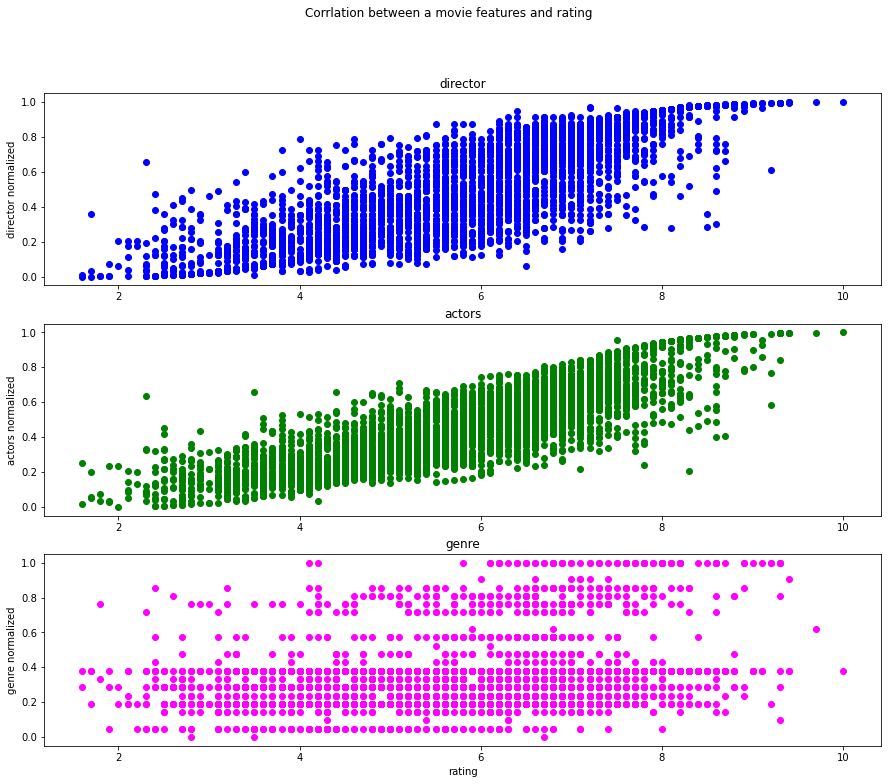

In [53]:
fig, ax = plt.subplots(3, figsize=(15,12))

ax[0].scatter(df_pr['rating'], scaled['director'], facecolor='blue')
ax[0].set_ylabel('director normalized')
ax[0].set_title('director')

ax[1].scatter(df_pr['rating'], scaled['actors'], facecolor='green')
ax[1].set_ylabel('actors normalized')
ax[1].set_title('actors')

ax[2].scatter(df_pr['rating'], scaled['genre'], facecolor='magenta')
ax[2].set_xlabel('rating')
ax[2].set_ylabel('genre normalized')
ax[2].set_title('genre')

fig.suptitle("Corrlation between a movie features and rating")

Histogram for ratings

Text(0.5, 1.0, 'Rating Histogram')

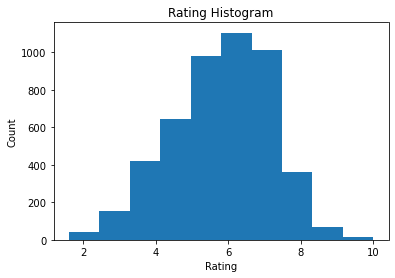

In [54]:
plt.hist(df_pr.rating)

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Histogram')

Histogram for Year

Text(0.5, 1.0, 'Year Histogram')

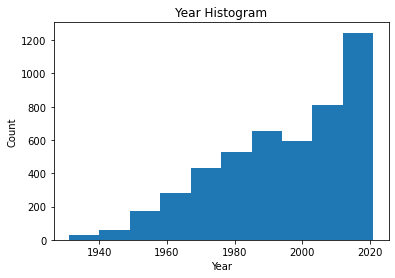

In [55]:
plt.hist(df_pr.year)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Histogram')

In [56]:
#plot correlation matrix for variables
cor = df_pr.corr()
cor.style.background_gradient(cmap = 'BrBG')  

,year,genre,duration,director,actors,votes,rating
year,1.000000,-0.028746,-0.406993,-0.283408,-0.330662,0.211091,-0.258938
genre,-0.028746,1.000000,-0.166701,0.309829,0.313659,-0.074116,0.287905
duration,-0.406993,-0.166701,1.000000,-0.075242,-0.101319,0.121438,-0.050463
director,-0.283408,0.309829,-0.075242,1.000000,0.810496,-0.063715,0.828387
actors,-0.330662,0.313659,-0.101319,0.810496,1.000000,-0.141879,0.839752
votes,0.211091,-0.074116,0.121438,-0.063715,-0.141879,1.000000,-0.000736
rating,-0.258938,0.287905,-0.050463,0.828387,0.839752,-0.000736,1.000000


<AxesSubplot:>

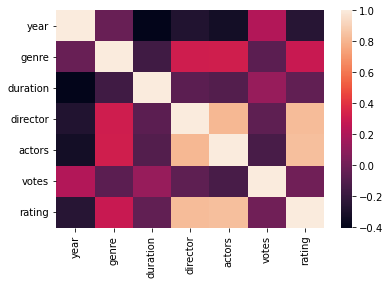

In [57]:
sns.heatmap(cor)

<a id='tts'></a>
## 3.4 Train Test Split

Splitting into Train and Test set (70% : 30%)

Creating Two Models

1. Model1: based on 2 features: 'director', 'actors'
2. Model2: based on all features except 'movie'

In [58]:
#Seperate dataframe for target (rating)
y = pd.DataFrame()
y['rating'] = df_pr['rating']

In [59]:
#dataframe for features ['year', 'genre', 'duration', 'director', 'actors', 'votes']
#dropping target and movie name
X = df_pr.drop(['movie', 'rating'], axis = 1).copy(True)

Replacing categorical values of director, actors, genre with numerical scaled values 

In [60]:
X[['director', 'actors', 'genre']] = scaled[['director', 'actors', 'genre']]

In [61]:
X.sample(5)

,year,genre,duration,director,actors,votes
1365,2002,0.285714,147,0.283465,0.277344,50
1441,2000,0.380952,115,0.442695,0.404864,15
4769,2014,0.285714,141,0.701225,0.541818,449
456,2019,0.190476,107,0.304899,0.146842,1204
4273,2009,0.238095,155,0.663605,0.401950,210


In [62]:
X.shape

(4803, 6)

In [63]:
# custom train test split
# test_frac is the fraction of data that is to be used as test data
def train_test_val_split(X, y, test_frac):
    #splitting training from rest of the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_frac)
    return (X_train, y_train), (X_test, y_test)

**Model1 (features: [director, actors])**

In [64]:
(X_train1, y_train1), (X_test1, y_test1) = train_test_val_split(X[['director', 'actors']], y, 0.3)
X_train1.shape, X_test1.shape

((3362, 2), (1441, 2))

**Model2 (features: [year, genre, duration, director, actors, votes])**

In [65]:
(X_train2, y_train2), (X_test2, y_test2) = train_test_val_split(X, y, 0.3)
X_train2.shape, X_test2.shape

((3362, 6), (1441, 6))

<a id='mb'></a>
# 4. Model Building

We will be building the following models:
1. Linear Regression
2. DecisionTreeRegressor
3. RandomForestRegressor
4. KNeighborsRegressor
5. GradientBoostingRegressor
6. BayesianRidge

Metrics we will be using: 

- r2_score
- mean_absolute_error
- mean_squared_error

Major Steps for each model:
1. Create object for model
2. fit model object on training data
3. predict ratings on trained model
4. get accuracies and errors

<a id='lr'></a>
## 4.1 Linear Regressor ([#](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html))

**Model1**

In [66]:
lr1 = LinearRegression()
lr1.fit(X_train1.values, y_train1.values.ravel())
y_pred_lr1 = lr1.predict(X_test1.values)

In [67]:
print('Scores for Linear Regression with Model1: ')

score_lr1_r2 = r2_score(y_test1, y_pred_lr1)
print("r2:                 ", score_lr1_r2)

score_lr1_mae = mean_absolute_error(y_test1, y_pred_lr1)
print("mean absolute error:", score_lr1_mae)

score_lr1_mse = mean_squared_error(y_test1, y_pred_lr1)
print("mean squared error: ", score_lr1_mse)

Scores for Linear Regression with Model1: 
r2:                  0.757730964563754
mean absolute error: 0.4917059172560399
mean squared error:  0.42566949109390273


**Model2** (better)

In [68]:
lr2 = LinearRegression()
lr2.fit(X_train2.values, y_train2.values.ravel())
y_pred_lr2 = lr2.predict(X_test2.values)

In [69]:
print('Scores for Linear Regression with Model2: \n')

score_lr2_r2 = r2_score(y_test2, y_pred_lr2)
print("r2:                 ", score_lr2_r2)

score_lr2_mae = mean_absolute_error(y_test2, y_pred_lr2)
print("mean absolute error:", score_lr2_mae)

score_lr2_mse = mean_squared_error(y_test2, y_pred_lr2)
print("mean squared error: ", score_lr2_mse)

Scores for Linear Regression with Model2: 

r2:                  0.7784565026411756
mean absolute error: 0.4887665098978795
mean squared error:  0.41104760695459724


<a id='dtr'></a>
## 4.2 Decision Tree Regressor ([#](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html))

**Model1**

In [70]:
dtr1 = DecisionTreeRegressor(random_state = 0) 
dtr1.fit(X_train1.values, y_train1.values.ravel())
y_pred_dtr1 = dtr1.predict(X_test1.values)

In [71]:
print('Scores for Decision Tree Regression with Model1: \n')

score_dtr1_r2 = r2_score(y_test1, y_pred_dtr1)
print("r2:                 ", score_dtr1_r2)

score_dtr1_mae = mean_absolute_error(y_test1, y_pred_dtr1)
print("mean absolute error:", score_dtr1_mae)

score_dtr1_mse = mean_squared_error(y_test1, y_pred_dtr1)
print("mean squared error: ", score_dtr1_mse)

Scores for Decision Tree Regression with Model1: 

r2:                  0.5789438664183271
mean absolute error: 0.5899722414989591
mean squared error:  0.7398004857737681


**Model2** (better)

In [72]:
dtr2 = DecisionTreeRegressor(random_state = 0) 
dtr2.fit(X_train2.values, y_train2.values.ravel())
y_pred_dtr2 = dtr2.predict(X_test2.values)

In [73]:
print('Scores for Decision Tree Regression with Model2: \n')

score_dtr2_r2 = r2_score(y_test2, y_pred_dtr2)
print("r2:                 ", score_dtr2_r2)

score_dtr2_mae = mean_absolute_error(y_test2, y_pred_dtr2)
print("mean absolute error:", score_dtr2_mae)

score_dtr2_mse = mean_squared_error(y_test2, y_pred_dtr2)
print("mean squared error: ", score_dtr2_mse)

Scores for Decision Tree Regression with Model2: 

r2:                  0.6138321293826985
mean absolute error: 0.5895905621096461
mean squared error:  0.7164885496183206


<a id='rfr'></a>
## 4.3 Random Forest Regressor ([#](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor))

**Model1**

In [74]:
rfr1 = RandomForestRegressor(random_state = 0)
rfr1.fit(X_train1.values, y_train1.values.ravel())
y_pred_rfr1 = rfr1.predict(X_test1.values)

In [75]:
print('Scores for Random Forest Regression with Model1: \n')

score_rfr1_r2 = r2_score(y_test1, y_pred_rfr1)
print("r2:                 ", score_rfr1_r2)

score_rfr1_mae = mean_absolute_error(y_test1, y_pred_rfr1)
print("mean absolute error:", score_rfr1_mae)

score_rfr1_mse = mean_squared_error(y_test1, y_pred_rfr1)
print("mean squared error: ", score_rfr1_mse)

Scores for Random Forest Regression with Model1: 

r2:                  0.7488068159748131
mean absolute error: 0.466431266316381
mean squared error:  0.4413493231511053


**Model2** (better)

In [76]:
rfr2 = RandomForestRegressor(random_state = 0)
rfr2.fit(X_train2.values, y_train2.values.ravel())
y_pred_rfr2 = rfr2.predict(X_test2.values)

In [77]:
print('Scores for Random Forest Regression with Model2: \n')

score_rfr2_r2 = r2_score(y_test2, y_pred_rfr2)
print("r2:                 ", score_rfr2_r2)

score_rfr2_mae = mean_absolute_error(y_test2, y_pred_rfr2)
print("mean absolute error:", score_rfr2_mae)

score_rfr2_mse = mean_squared_error(y_test2, y_pred_rfr2)
print("mean squared error: ", score_rfr2_mse)

Scores for Random Forest Regression with Model2: 

r2:                  0.8054824354535505
mean absolute error: 0.41561485079805677
mean squared error:  0.3609042033310202


<a id='knnr'></a>
## 4.4 K Neighbors Regressor ([#](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html))

**Model1** (better)

In [78]:
knnr1 = KNeighborsRegressor()
knnr1.fit(X_train1.values, y_train1.values.ravel())
y_pred_knnr1 = knnr1.predict(X_test1.values)

In [79]:
print('Scores for KNearest Neighbor Regression with Model1: \n')

score_knnr1_r2 = r2_score(y_test1, y_pred_knnr1)
print("r2:                 ", score_knnr1_r2)

score_knnr1_mae = mean_absolute_error(y_test1, y_pred_knnr1)
print("mean absolute error:", score_knnr1_mae)

score_knnr1_mse = mean_squared_error(y_test1, y_pred_knnr1)
print("mean squared error: ", score_knnr1_mse)

Scores for KNearest Neighbor Regression with Model1: 

r2:                  0.7491780754543577
mean absolute error: 0.4787647467036781
mean squared error:  0.4406970159611381


**Model2** (poor performance)

In [80]:
knnr2 = KNeighborsRegressor()
knnr2.fit(X_train2.values, y_train2.values.ravel())
y_pred_knnr2 = knnr2.predict(X_test2.values)

In [81]:
print('Scores for KNearest Neighbor Regression with Model2: \n')

score_knnr2_r2 = r2_score(y_test2, y_pred_knnr2)
print("r2:                 ", score_knnr2_r2)

score_knnr2_mae = mean_absolute_error(y_test2, y_pred_knnr2)
print("mean absolute error:", score_knnr2_mae)

score_knnr2_mse = mean_squared_error(y_test2, y_pred_knnr2)
print("mean squared error: ", score_knnr2_mse)

Scores for KNearest Neighbor Regression with Model2: 

r2:                  0.1266313494547342
mean absolute error: 0.9887439278278973
mean squared error:  1.6204316446911868


<a id='gbr'></a>
## 4.5 Gradient Boosting Regressor ([#](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html))

**Model1**

In [82]:
gbr1 = GradientBoostingRegressor(random_state=0)
gbr1.fit(X_train1.values, y_train1.values.ravel())
y_pred_gbr1 = gbr1.predict(X_test1.values)

In [83]:
print('Scores for Gradient Boosting Regression with Model1: \n')

score_gbr1_r2 = r2_score(y_test1, y_pred_gbr1)
print("r2:                 ", score_gbr1_r2)

score_gbr1_mae = mean_absolute_error(y_test1, y_pred_gbr1)
print("mean absolute error:", score_gbr1_mae)

score_gbr1_mse = mean_squared_error(y_test1, y_pred_gbr1)
print("mean squared error: ", score_gbr1_mse)

Scores for Gradient Boosting Regression with Model1: 

r2:                  0.7824093575733184
mean absolute error: 0.4400888288147361
mean squared error:  0.3823092697825788


**Model2** (better)

In [84]:
gbr2 = GradientBoostingRegressor(random_state=0)
gbr2.fit(X_train2.values, y_train2.values.ravel())
y_pred_gbr2 = gbr2.predict(X_test2.values)

In [85]:
print('Scores for Gradient Boosting Regression with Model2: \n')

score_gbr2_r2 = r2_score(y_test2, y_pred_gbr2)
print("r2:                 ", score_gbr2_r2)

score_gbr2_mae = mean_absolute_error(y_test2, y_pred_gbr2)
print("mean absolute error:", score_gbr2_mae)

score_gbr2_mse = mean_squared_error(y_test2, y_pred_gbr2)
print("mean squared error: ", score_gbr2_mse)

Scores for Gradient Boosting Regression with Model2: 

r2:                  0.8161593701373466
mean absolute error: 0.4188339648112193
mean squared error:  0.34109442103677073


<a id='brr'></a>
## 4.6 Bayesian Ridge Regressor ([#](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html))

**Model1**

In [86]:
brr1 = BayesianRidge()
brr1.fit(X_train1.values, y_train1.values.ravel())
y_pred_brr1 = brr1.predict(X_test1.values)

In [87]:
print('Scores for Bayesian Ridge Regression with Model1: \n')

score_brr1_r2 = r2_score(y_test1, y_pred_brr1)
print("r2:                 ", score_brr1_r2)

score_brr1_mae = mean_absolute_error(y_test1, y_pred_brr1)
print("mean absolute error:", score_brr1_mae)

score_brr1_mse = mean_squared_error(y_test1, y_pred_brr1)
print("mean squared error: ", score_brr1_mse)

Scores for Bayesian Ridge Regression with Model1: 

r2:                  0.7577445658420175
mean absolute error: 0.49165983468373786
mean squared error:  0.4256455934910323


**Model2** (better)

In [88]:
brr2 = BayesianRidge()
brr2.fit(X_train2.values, y_train2.values.ravel())
y_pred_brr2 = brr2.predict(X_test2.values)

In [89]:
print('Scores for Bayesian Ridge Regression with Model2: \n')

score_brr2_r2 = r2_score(y_test2, y_pred_brr2)
print("r2:                 ", score_brr2_r2)

score_brr2_mae = mean_absolute_error(y_test2, y_pred_brr2)
print("mean absolute error:", score_brr2_mae)

score_brr2_mse = mean_squared_error(y_test2, y_pred_brr2)
print("mean squared error: ", score_brr2_mse)

Scores for Bayesian Ridge Regression with Model2: 

r2:                  0.7784765984862221
mean absolute error: 0.48868397537970587
mean squared error:  0.4110103215044959


## Visualization

plotting test ratings vs predictions for best model of all regression models

Text(0.5, 0.98, 'Predicted Ratings vs Test Ratings')

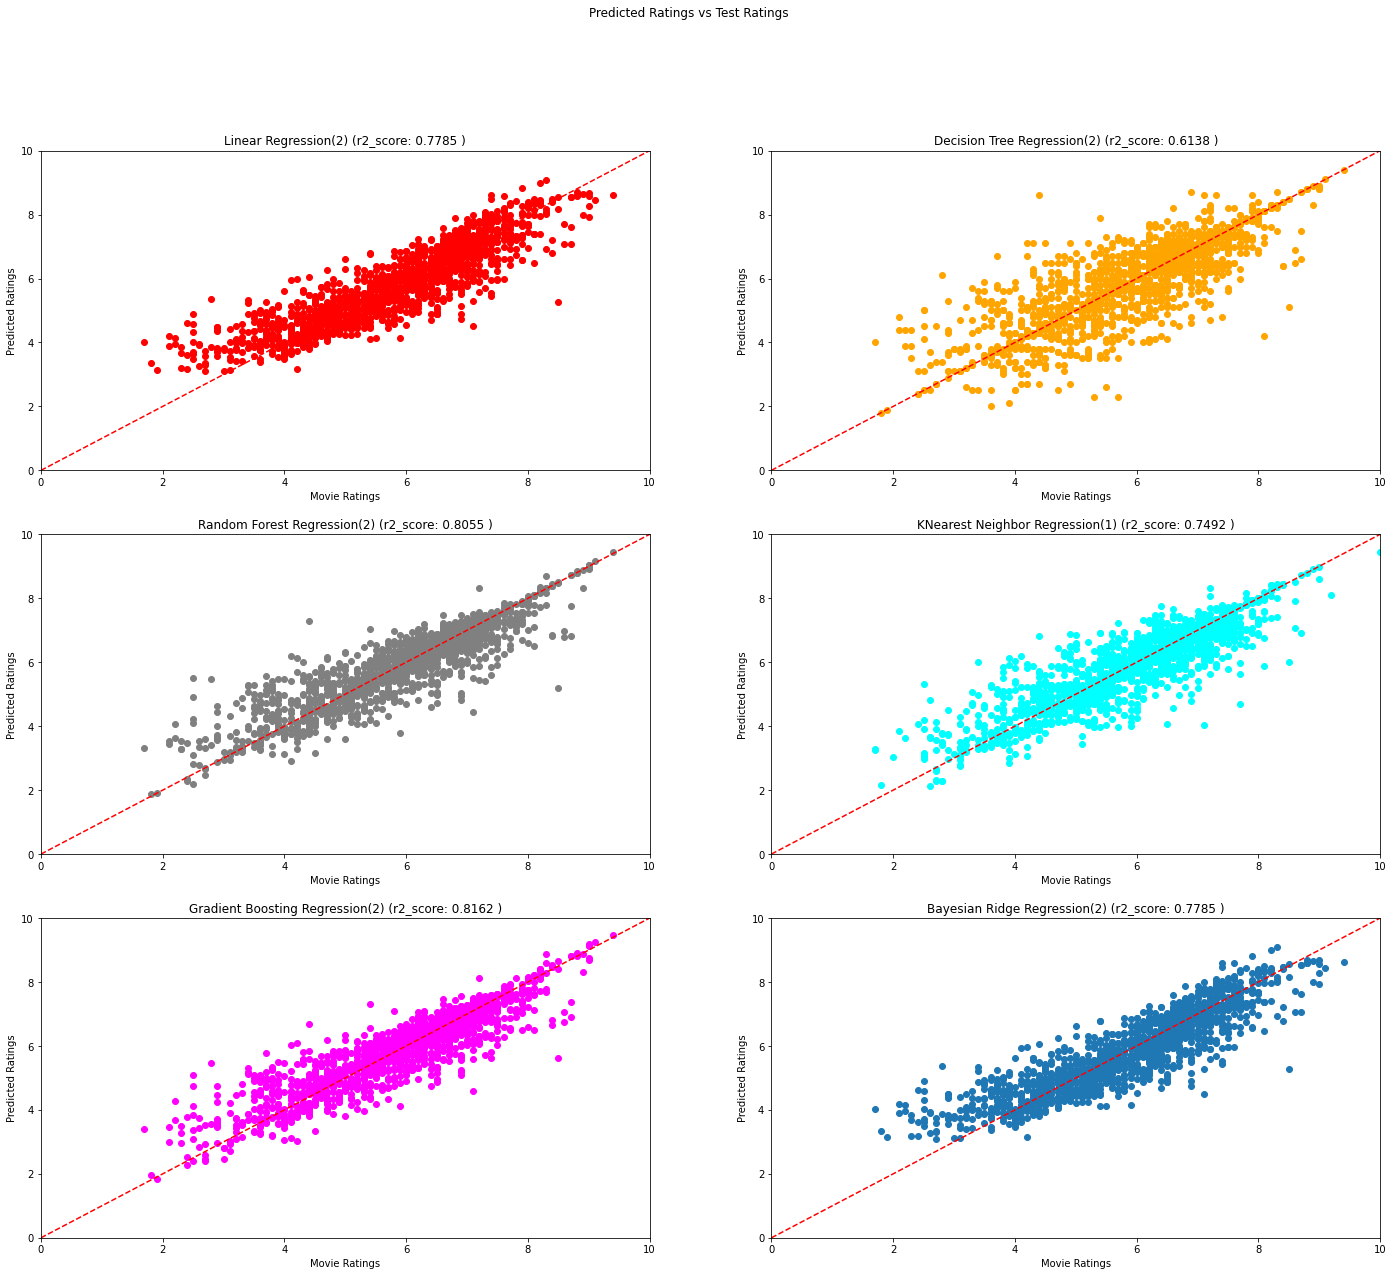

In [90]:
fig, ax = plt.subplots(3, 2, figsize=(24,20))
index_arr = [n for n in range(11)]

ax[0,0].axis([0,10,0,10])
ax[0,0].scatter(y_test2, y_pred_lr2, color="red")
ax[0,0].plot(index_arr,'r--')
ax[0,0].set_xlabel("Movie Ratings")
ax[0,0].set_ylabel("Predicted Ratings")
ax[0,0].set_title(f"Linear Regression(2) (r2_score: {round(score_lr2_r2, 4)} )")

ax[0,1].axis([0,10,0,10])
ax[0,1].scatter(y_test2, y_pred_dtr2, color="orange")
ax[0,1].plot(index_arr,'r--')             
ax[0,1].set_xlabel("Movie Ratings")
ax[0,1].set_ylabel("Predicted Ratings")
ax[0,1].set_title(f"Decision Tree Regression(2) (r2_score: {round(score_dtr2_r2, 4)} )")

ax[1,0].axis([0,10,0,10])
ax[1,0].scatter(y_test2, y_pred_rfr2, color="gray")
ax[1,0].plot(index_arr,'r--')             
ax[1,0].set_xlabel("Movie Ratings")
ax[1,0].set_ylabel("Predicted Ratings")
ax[1,0].set_title(f"Random Forest Regression(2) (r2_score: {round(score_rfr2_r2, 4)} )")

ax[1,1].axis([0,10,0,10])
ax[1,1].scatter(y_test1, y_pred_knnr1, color="cyan")
ax[1,1].plot(index_arr,'r--')             
ax[1,1].set_xlabel("Movie Ratings")
ax[1,1].set_ylabel("Predicted Ratings")
ax[1,1].set_title(f"KNearest Neighbor Regression(1) (r2_score: {round(score_knnr1_r2, 4)} )")

ax[2,0].axis([0,10,0,10])
ax[2,0].scatter(y_test2, y_pred_gbr2, color="magenta")
ax[2,0].plot(index_arr,'r--')             
ax[2,0].set_xlabel("Movie Ratings")
ax[2,0].set_ylabel("Predicted Ratings")
ax[2,0].set_title(f"Gradient Boosting Regression(2) (r2_score: {round(score_gbr2_r2, 4)} )")

ax[2,1].axis([0,10,0,10])
ax[2,1].scatter(y_test2, y_pred_brr2)
ax[2,1].plot(index_arr,'r--')             
ax[2,1].set_xlabel("Movie Ratings")
ax[2,1].set_ylabel("Predicted Ratings")
ax[2,1].set_title(f"Bayesian Ridge Regression(2) (r2_score: {round(score_brr2_r2, 4)} )")

fig.suptitle("Predicted Ratings vs Test Ratings")

## Summarization

<table>
    <tr>
        <th>Regression Algorithm</th>
        <th>Better Model(1 or 2)</th>
        <th>r2_score</th>
    </tr>
    <tr>
        <td>Linear Regression</td>
        <td>2</td>
        <td>0.7785</td>
    </tr>
    <tr>
        <td>Decision Tree Regression</td>
        <td>2</td>
        <td>0.6138</td>
    </tr>
    <tr>
        <td>Random Forest Regression</td>
        <td>2</td>
        <td>0.8055</td>
    </tr>
    <tr>
        <td>KNearest Neighbor Regression</td>
        <td>1</td>
        <td>0.7492</td>
    </tr>
    <tr>
        <td>Gradient Boosting Regression</td>
        <td>2</td>
        <td>0.8162</td>
    </tr>
    <tr>
        <td>Bayesian Ridge Regression</td>
        <td>2</td>
        <td>0.7785</td>
    </tr>
</table>

<a id='mes'></a>
# 5. Model Evaluation and Selection ([#](https://scikit-learn.org/stable/modules/model_evaluation.html))

Based on Evaluation Metrics (r2_score), it can be concluded that considering all features grants better performance

The best Performing Regression Algorithm was Gradient Boosting Regression with an r2_score = 0.8162

In [91]:
print('r2_scores (model2):')
print(f'linear regression:            {round(score_lr2_r2, 4)}')
print(f'decision tree regression:     {round(score_dtr2_r2, 4)}')
print(f'random forest regression:     {round(score_rfr2_r2, 4)}')
print(f'knearest neighbor regression: {round(score_knnr2_r2, 4)}')
print(f'gradient boosting regression: {round(score_gbr2_r2, 4)}')
print(f'bayesian ridge regressionr:   {round(score_brr2_r2, 4)}')

r2_scores (model2):
linear regression:            0.7785
decision tree regression:     0.6138
random forest regression:     0.8055
knearest neighbor regression: 0.1266
gradient boosting regression: 0.8162
bayesian ridge regressionr:   0.7785


Next, hyperparameter tuning of **Gradient Boosting Regressor**

<a id='hpt'></a>
## Hyperparameter Tuning

using Random Search CV

In [92]:
# parameter grid for random search CV
param_grid = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500], # number of boosting stages that will be performed
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1) #shrinks the contribution of each tree by learning_rate
}

In [93]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

In [94]:
# random search to select best parameters based on r2 metrics
search_cv = RSCV(
    GradientBoostingRegressor(), 
    param_distributions=param_grid, 
    scoring="r2", 
    n_iter=20, 
    random_state=0, 
    n_jobs=2,
    cv = crossvalidation,
    return_train_score = True
)

In [95]:
# fitting on training data
search_cv.fit(X_train2.values, y_train2.values.ravel())

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
                   estimator=GradientBoostingRegressor(), n_iter=20, n_jobs=2,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f84c33ebad0>,
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100],
                                        'n_estimators': [1, 2, 5, 10, 20, 50,
                                                         100, 200, 500]},
                   random_state=0, return_train_score=True, scoring='r2')

In [96]:
# tabulating results of random search
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,mean_test_error,std_test_error
12,200,50,0.110585,-0.818277,0.011137
10,200,20,0.109889,-0.817094,0.012221
1,200,20,0.160519,-0.813487,0.012066
3,500,2,0.07502,-0.799458,0.012990
4,100,5,0.0351,-0.799261,0.011338
18,10,5,0.637819,-0.790037,0.018103
6,500,100,0.709894,-0.727606,0.028188
17,500,5,0.771785,-0.715455,0.027200
19,5,20,0.202432,-0.687221,0.007505
8,5,2,0.462636,-0.686721,0.015253


In [97]:
error = -search_cv.score(X_test2.values, y_test2.values.ravel())
print(f"On average, Gradient Boosting regressor makes an error of {error:.2f} k$")

On average, Gradient Boosting regressor makes an error of -0.81 k$


In [98]:
gbr_params = search_cv.best_estimator_
print('Best Params: ', gbr_params)

Best Params:  GradientBoostingRegressor(learning_rate=0.11058510725696458, max_leaf_nodes=50,
                          n_estimators=200)


In [99]:
search_cv

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
                   estimator=GradientBoostingRegressor(), n_iter=20, n_jobs=2,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f84c33ebad0>,
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100],
                                        'n_estimators': [1, 2, 5, 10, 20, 50,
                                                         100, 200, 500]},
                   random_state=0, return_train_score=True, scoring='r2')

<a id='final-model'></a>
## Creating Final Model (Gradient Boosting Regressor)

In [100]:
# creating model object based on tuned parameters
model = GradientBoostingRegressor(
    learning_rate=0.1098891866898283, 
    max_leaf_nodes=20,
    n_estimators=200
)

In [101]:
#fitting and predicting on test data
model.fit(X_train2.values, y_train2.values.ravel())
y_pred = model.predict(X_test2.values)

In [102]:
print('Scores for Final Model: \n')

r2 = r2_score(y_test2, y_pred_gbr2)
print("r2:                 ", r2)
mae = mean_absolute_error(y_test2, y_pred)
print("mean absolute error:", mae)
mse = mean_squared_error(y_test2, y_pred)
print("mean squared error: ", mse)

Scores for Final Model: 

r2:                  0.8161593701373466
mean absolute error: 0.41934072746417167
mean squared error:  0.34281044164991875


<a id = 'sm'></a>
## Saving model and Lists

using pickle

In [103]:
#save model
with open('movie-rating-gbr-r2-81.pkl', 'wb') as f:
    pickle.dump(model, f)

In [104]:
with open("genre_list.txt", "w") as f:
    f.write(str(genre_list))
with open("director_list.txt", "w") as f:
    f.write(str(director_list))
with open("actors_list.txt", "w") as f:
    f.write(str(actors_list))

<a id='sp'></a>
# 6. Sample Predictions

add all preprocessing steps into driver function

read input

show predictions

**Load Saved Model and Saved Lists**

In [105]:
#load model
with open('movie-rating-gbr-r2-81.pkl', 'rb') as f:
    model = pickle.load(f) 

In [ ]:
with open("director_list.txt", "r") as f:
    director_list = eval(f.readline())
with open("actors_list.txt", "r") as f:
    actors_list = eval(f.readline())
with open("genre_list.txt", "r") as f:
    genre_list = eval(f.readline())

In [106]:
# movie(str), year (int), genre(list of str), duration(int), director(list of str), actors(list of str), votes(int)
samples = {
    'movie': ['Andhadun', 'Chakde India', 'Jai Hind', 'Roz', 'Ek Din', 'Shuruat', 'Sadaev', 'Shara', 'Mahadev', 'Neta'],
    'year' : [1990, 1940, 2020, 2013, 1970, 2000, 1900, 2005, 1999, 1983],
    'genre' : [
        ['Thriller','Action','Crime'], ['War'], ['Family', 'Fantasy'], ['Documentary', 'Biography'], 
        ['Comedy', 'Drama'], ['Sci-Fi', 'Thriller'], ['Adventure', 'Animation'], ['History', ' News'], 
        ['Romance', 'Mystery'], ['Music', 'Drama', 'Musical']
    ],
    'duration' : [300, 200, 10, 400, 150, 100, 90, 190, 270, 230], 
    'director' : [
        ['Mahesh Nair'], ['Janak Toprani'], ['Rajiv Chilaka'], ['Sudhish Kumar Sharma'], 
        ['J. Om Prakash'], ['Ravi Raja'], ['Raj Shetty'] ,['Deepak Ramsay'] ,['Pappu Verma'] ,['K. Mishra']
    ],
    'actors' : [
        ['Farah Khan', 'Shah Rukh Khan'], ['Rajkummar Rao', 'Akshay Kumar', 'Janhvi Kapoor'], 
        ['Khurshid Begum', 'Vidya Sinha', 'Danny Denzongpa'], ['Tom Alter', 'Hansa Wadkar'], 
        ['Chitram Basha', 'Abhijeet Sawant'], ['Ayushmann Khurrana', 'Ekaterina Antonova'], 
        ['Ajay Devgn', 'Abhishek Bachchan'] ,['Eddie Billimoria', 'Kriti Malhotra', 'Durgesh Nandini'], 
        ['Hemanta Mukherjee', 'Sanjay Dutt'], ['Rajinikanth', 'Karisma Kapoor', 'Kiran Kumar']
    ],
    'votes' : [10, 1, 300, 4000, 500, 50, 1000, 2101, 760, 20]
}
#convert into dataframe
df = pd.DataFrame.from_dict(samples)

In [107]:
#function to process raw input data and return cleaned dataframe
def process(df):
    #remove movie
    df.drop(['movie'], axis=1, inplace=True)
    
    #Step 1: Creating Binary Representation for each feature based on all unique values
    # repeat for director, actors, genre
    fts, ftslist = ['director', 'actors', 'genre'], [director_list, actors_list, genre_list]
    for i in range(3):
        df[fts[i]] = df[fts[i]].apply(lambda x: calculate_bin_array(x, ftslist[i]))
    
    #Step 2: Find Concentration Points in each Array
    # repeat for director, actors, genre
    df = to_conc(df, fts)
    
    #Step 3: Find decimal value to represents concentration points
    # repeat for director, actors, genre
    df = to_weighted_avg(df, fts)
    
    #Step 4: Normalize Features
    to_scale = pd.DataFrame()
    to_scale = df[['genre', 'director', 'actors']]
    scaler = MinMaxScaler()
    scaled = pd.DataFrame(scaler.fit_transform(to_scale.astype(float)))
    scaled.index = to_scale.index
    scaled.columns = to_scale.columns
    
    #replace categorical values in df with scaled numerical
    df[['director', 'actors', 'genre']] = scaled[['director', 'actors', 'genre']]
    
    return df

In [108]:
raw = df.copy(True)
clean = process(raw)
df['Predicted-Rating'] = model.predict(clean.values)

feature:  director
feature:  actors
feature:  genre
Current:  director
Current:  actors
Current:  genre


In [109]:
df

,movie,year,genre,duration,director,actors,votes,Predicted-Rating
0,Andhadun,1990,"[Thriller, Action, Crime]",300,[Mahesh Nair],"[Farah Khan, Shah Rukh Khan]",10,0.849009
1,Chakde India,1940,[War],200,[Janak Toprani],"[Rajkummar Rao, Akshay Kumar, Janhvi Kapoor]",1,5.079125
2,Jai Hind,2020,"[Family, Fantasy]",10,[Rajiv Chilaka],"[Khurshid Begum, Vidya Sinha, Danny Denzongpa]",300,8.962166
3,Roz,2013,"[Documentary, Biography]",400,[Sudhish Kumar Sharma],"[Tom Alter, Hansa Wadkar]",4000,8.492284
4,Ek Din,1970,"[Comedy, Drama]",150,[J. Om Prakash],"[Chitram Basha, Abhijeet Sawant]",500,5.599345
5,Shuruat,2000,"[Sci-Fi, Thriller]",100,[Ravi Raja],"[Ayushmann Khurrana, Ekaterina Antonova]",50,7.801315
6,Sadaev,1900,"[Adventure, Animation]",90,[Raj Shetty],"[Ajay Devgn, Abhishek Bachchan]",1000,4.453534
7,Shara,2005,"[History, News]",190,[Deepak Ramsay],"[Eddie Billimoria, Kriti Malhotra, Durgesh Nan...",2101,6.557149
8,Mahadev,1999,"[Romance, Mystery]",270,[Pappu Verma],"[Hemanta Mukherjee, Sanjay Dutt]",760,4.601002
9,Neta,1983,"[Music, Drama, Musical]",230,[K. Mishra],"[Rajinikanth, Karisma Kapoor, Kiran Kumar]",20,4.756662
